In [ ]:
# data cleaning package
!pip install openpyxl
import openpyxl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# model package
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn import linear_model, metrics, preprocessing, model_selection
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import confusion_matrix
from pylab import rcParams
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**Data cleaning**

In [ ]:
clean = pd.read_csv('clean_data1.csv')
credit = pd.read_csv('credit_record.csv')

**Rearrange 'STATUS' in the 'credit_record' dataset**

In [ ]:
convert_to = {'C' : 'Good_Debt', 'X' : 'Good_Debt', '0' : 'Good_Debt',
              '1' : 'Neutral_Debt', '2' : 'Neutral_Debt', '3' : 'Bad_Debt', 
              '4' : 'Bad_Debt', '5' : 'Bad_Debt'}
credit.replace({'STATUS' : convert_to}, inplace=True)
credit = credit.value_counts(subset=['ID', 'STATUS']).unstack(fill_value=0)
#credit

**Create new feature 'CREDIT_APPROVAL_STATUS' in the 'credit_record' dataset**

In [ ]:
credit.loc[(credit['Good_Debt'] > credit['Neutral_Debt']), 'CREDIT_APPROVAL_STATUS'] = 1
credit.loc[(credit['Good_Debt'] > credit['Bad_Debt']), 'CREDIT_APPROVAL_STATUS'] = 1
credit.loc[(credit['Neutral_Debt'] > credit['Good_Debt']), 'CREDIT_APPROVAL_STATUS'] = 0
credit.loc[(credit['Neutral_Debt'] > credit['Bad_Debt']), 'CREDIT_APPROVAL_STATUS'] = 1
credit.loc[(credit['Bad_Debt'] > credit['Good_Debt']), 'CREDIT_APPROVAL_STATUS'] = 0
credit.loc[(credit['Bad_Debt'] > credit['Neutral_Debt']), 'CREDIT_APPROVAL_STATUS'] = 0

np.unique(credit['CREDIT_APPROVAL_STATUS'])
credit['CREDIT_APPROVAL_STATUS'] = credit['CREDIT_APPROVAL_STATUS'].astype('int')
credit

STATUS,Bad_Debt,Good_Debt,Neutral_Debt,CREDIT_APPROVAL_STATUS
ID,,,,
5001711,0,4,0,1
5001712,0,19,0,1
5001713,0,22,0,1
5001714,0,15,0,1
5001715,0,60,0,1
...,...,...,...,...
5150482,0,18,0,1
5150483,0,18,0,1
5150484,0,13,0,1


**Merging two datasets**

In [ ]:
Final = clean.merge(credit, how='inner', on=['ID'])
#Final.head(10)

**Encoding categorical features to numerical values**

In [ ]:
def Cat_to_Num(features):
    for feature in features:
        feature_list = list(np.unique(Final[feature]))
        feature_dict = {}
        for i in range(len(feature_list)):
                       feature_dict[feature_list[i]] = i
        Final.replace({feature : feature_dict}, inplace=True)
        print(feature, '-->', feature_dict)

categorical_features = ['Income_type', 'Education_type', 'Family_status', 'Housing_type', 'Occupation_type']
Cat_to_Num(categorical_features)

Income_type --> {'Commercial associate': 0, 'Pensioner': 1, 'State servant': 2, 'Student': 3, 'Working': 4}
Education_type --> {'Academic degree': 0, 'Higher education': 1, 'Incomplete higher': 2, 'Lower secondary': 3, 'Secondary / secondary special': 4}
Family_status --> {'Civil marriage': 0, 'Married': 1, 'Separated': 2, 'Single / not married': 3, 'Widow': 4}
Housing_type --> {'Co-op apartment': 0, 'House / apartment': 1, 'Municipal apartment': 2, 'Office apartment': 3, 'Rented apartment': 4, 'With parents': 5}
Occupation_type --> {'Accountants': 0, 'Cleaning staff': 1, 'Cooking staff': 2, 'Core staff': 3, 'Drivers': 4, 'HR staff': 5, 'High skill tech staff': 6, 'IT staff': 7, 'Laborers': 8, 'Low-skill Laborers': 9, 'Managers': 10, 'Medicine staff': 11, 'Other': 12, 'Private service staff': 13, 'Realty agents': 14, 'Sales staff': 15, 'Secretaries': 16, 'Security staff': 17, 'Waiters/barmen staff': 18}


**Check missing data**

In [ ]:
Final=pd.read_csv('final_data.csv')
Final.isnull().sum()

ID                        0
Gender                    0
Own_car                   0
Own_property              0
Work_phone                0
Phone                     0
Email                     0
Unemployed                0
Num_children              0
Num_family                0
Account_length            0
Total_income              0
Age                       0
Years_employed            0
Income_type               0
Education_type            0
Family_status             0
Housing_type              0
Occupation_type           0
Target                    0
Bad_Debt                  0
Good_Debt                 0
Neutral_Debt              0
CREDIT_APPROVAL_STATUS    0
dtype: int64

The result shows there is no missing value in the "Final" dataset. 

**Check data balanced**

In [ ]:
Final["CREDIT_APPROVAL_STATUS"].value_counts()

1    9640
0      69
Name: CREDIT_APPROVAL_STATUS, dtype: int64

CREDIT_APPROVAL_STATUS 0.71 % of the dataset
CREDIT_APPROVAL_STATUS 99.29 % of the dataset


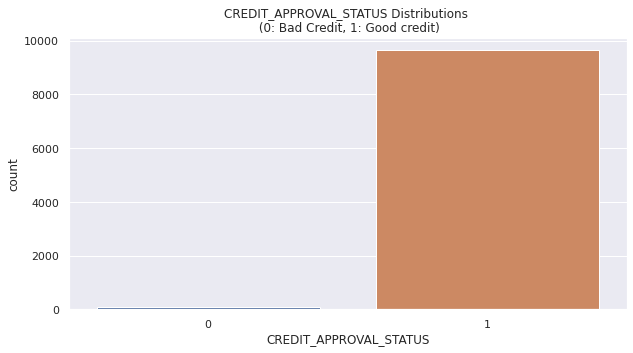

In [ ]:
print('CREDIT_APPROVAL_STATUS', round(Final['CREDIT_APPROVAL_STATUS'].value_counts()[0]/len(Final) * 100,2), '% of the dataset')
print('CREDIT_APPROVAL_STATUS', round(Final['CREDIT_APPROVAL_STATUS'].value_counts()[1]/len(Final) * 100,2), '% of the dataset')
sns.countplot('CREDIT_APPROVAL_STATUS', data = Final)
plt.title('CREDIT_APPROVAL_STATUS Distributions \n (0: Bad Credit, 1: Good credit)', fontsize = 12)
rcParams['figure.figsize'] = 5, 5

As the figure shows, the data is imbalance. Only 0.71% of the data has bad credit approval status while 99.29 % of the data has good credit approval status.

**Data discription**



In [ ]:
Final=pd.read_csv('final_data.csv')
Final.drop(['ID','Bad_Debt', 'Good_Debt', 'Neutral_Debt'], axis=1, inplace=True)

In [ ]:
Final.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,9709.0,5.076105e+06,40802.696053,5.008804e+06,5.036955e+06,5.069449e+06,5.112986e+06,5.150479e+06
Gender,9709.0,3.487486e-01,0.476599,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Own_car,9709.0,3.677001e-01,0.482204,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Own_property,9709.0,6.715419e-01,0.469677,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Work_phone,9709.0,2.174271e-01,0.412517,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Phone,9709.0,2.876712e-01,0.452700,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Email,9709.0,8.754764e-02,0.282650,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Unemployed,9709.0,1.746833e-01,0.379716,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Num_children,9709.0,4.228036e-01,0.767019,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.900000e+01
Num_family,9709.0,2.182614e+00,0.932918,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01


**Splitting the credit_approval_data into training and testing sets**

In [ ]:
Final=pd.read_csv('final_data.csv')
X = Final.drop(['ID','CREDIT_APPROVAL_STATUS','Bad_Debt', 'Good_Debt', 'Neutral_Debt'], axis=1)
y = Final['CREDIT_APPROVAL_STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Logistic Regression**


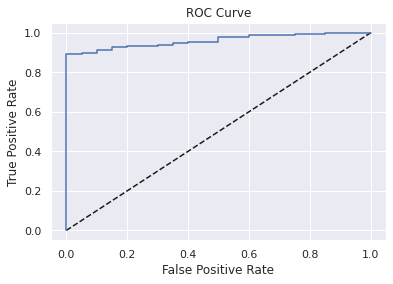

In [ ]:
scaler=StandardScaler()
X_train1=scaler.fit_transform(X_train)
X_test1=scaler.transform(X_test)

clf = LogisticRegressionCV(penalty='l2',solver='lbfgs',n_jobs=4,class_weight={1:140})
clf.fit(X_train1, y_train)

def plot_roc(mod, X, y):
    preds = clf.predict_proba(X_test1)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y, preds)

    # plot ROC curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    
plot_roc(clf, X_test1, y_test)

In [ ]:
prediction = clf.predict_proba(X_test1)[:,1]
roc_auc_score(y_test, prediction)

0.9594020048392673

The ROC-AUC score of Logistic model is 0.96. 

**Random Forest**


In [ ]:
# build the model and evaluate it
Final=pd.read_csv('final_data.csv')
X = Final.drop(['ID','CREDIT_APPROVAL_STATUS','Bad_Debt', 'Good_Debt', 'Neutral_Debt'], axis=1)
y = Final['CREDIT_APPROVAL_STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_jobs=4, n_estimators=100, max_features=4,class_weight={1:140})
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
roc_auc_score(y_test, preds)

0.5

In [ ]:
# contains more features
Final=pd.read_csv('final_data.csv')
X = Final.drop(['ID','CREDIT_APPROVAL_STATUS'], axis=1)
y = Final['CREDIT_APPROVAL_STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
Final["CREDIT_APPROVAL_STATUS"].value_counts()

1    9640
0      69
Name: CREDIT_APPROVAL_STATUS, dtype: int64

In [ ]:
clf = RandomForestClassifier(n_jobs=4, n_estimators=100, max_features=4,class_weight={1:140})
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
roc_auc_score(y_test, preds)

0.9246543380573798

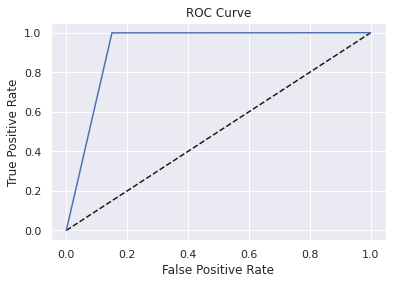

In [ ]:
def plot_roc(mod, X, y):
    prediction = clf.predict(X_test)
    fpr, tpr, _ = metrics.roc_curve(y, prediction)

    # plot ROC curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    
plot_roc(clf, X_test, y_test)

The first AUC score shows that initially the prediction performance of the random forest is very poor. However, when we add more features into this model, its AUC score is significantly improved, indicating that the model gets better classification.

**Support Vector Machine**

**Balance Data**

Train: [1930 1931 1932 ... 9706 9707 9708] Test: [   0    1    2 ... 4950 5002 5698]
Train: [   0    1    2 ... 9706 9707 9708] Test: [1930 1931 1932 ... 8619 8628 8901]
Train: [   0    1    2 ... 9706 9707 9708] Test: [3862 3863 3864 ... 9602 9606 9611]
Train: [   0    1    2 ... 9706 9707 9708] Test: [5798 5799 5800 ... 9642 9643 9647]
Train: [   0    1    2 ... 9642 9643 9647] Test: [7733 7734 7735 ... 9706 9707 9708]
--------------------------------------------------
Label Distributions: 

[0.00720906 0.99279094]
[0.00669758 0.99330242]
Distribution of the CREDIT_APPROVAL_STATUS in the subsample dataset
1    0.5
0    0.5
Name: CREDIT_APPROVAL_STATUS, dtype: float64


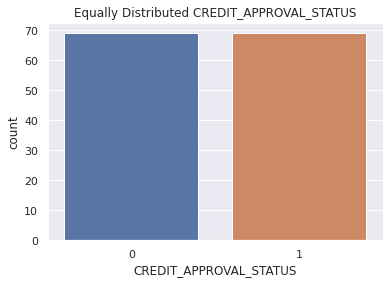

In [ ]:
X = Final.drop(['ID','CREDIT_APPROVAL_STATUS','Bad_Debt', 'Good_Debt', 'Neutral_Debt'], axis=1)
y = Final['CREDIT_APPROVAL_STATUS']

sss = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 50)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))


f = Final.sample(frac=1)

fraud_f = f.loc[Final['CREDIT_APPROVAL_STATUS'] == 0]
non_fraud_f = f.loc[Final['CREDIT_APPROVAL_STATUS'] == 1][:69]

normal_distributed_f = pd.concat([fraud_f, non_fraud_f])

new_f = normal_distributed_f.sample(frac = 1, random_state = 32)

print('Distribution of the CREDIT_APPROVAL_STATUS in the subsample dataset')
print(new_f['CREDIT_APPROVAL_STATUS'].value_counts()/len(new_f))

sns.countplot('CREDIT_APPROVAL_STATUS', data = new_f)
plt.title('Equally Distributed CREDIT_APPROVAL_STATUS', fontsize = 12)
plt.show()


**SVM Model**

We attain a training score of 55.00000000000001 % accuracy score
Support Vector Classifier Cross Validation Score 55.26%
Support Vector Classifier:  0.5204347826086957


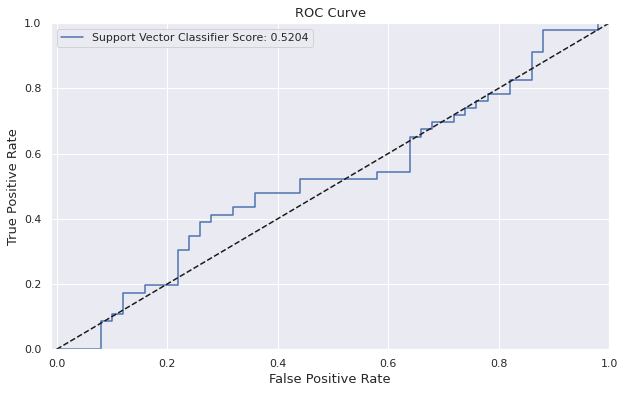

In [ ]:
X_1 = new_f.drop('CREDIT_APPROVAL_STATUS', axis=1)
y_1 = new_f['CREDIT_APPROVAL_STATUS']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size = 0.3, random_state = 42)

X_train1 = X_train1.values
X_test1 = X_test1.values
y_train1 = y_train1.values
y_test1 = y_test1.values


svmodel = SVC(kernel='linear')
svmodel.fit(X_train1, y_train1)

training_score = cross_val_score(svmodel, X_train1, y_train1, cv = 5)

print("We attain a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

# use GridSearchCV to find the best parameters.
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train1, y_train1)

# SVC best estimator
svc = grid_svc.best_estimator_

svc
svc_score = cross_val_score(svc, X_train1, y_train1, cv = 5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

svc_pred = cross_val_predict(svc, X_train1, y_train1, cv = 5, method = "decision_function")
print('Support Vector Classifier: ', roc_auc_score(y_train1, svc_pred))

svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train1, svc_pred)

# define a function to generate the ROC curve
def graph_roc_curve(svc_fpr, svc_tpr):
    plt.figure(figsize = (10, 6))
    plt.title('ROC Curve', fontsize = 13)
    plt.plot(svc_fpr, svc_tpr, 
             label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train1, svc_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.legend()

# plot the ROC curve
graph_roc_curve(svc_fpr, svc_tpr)
plt.show()

**Gradient Iterative Decision Tree(GBDT)-LightGBM**


In [ ]:
Final=pd.read_csv('final_data.csv')
X = Final.drop(['ID','CREDIT_APPROVAL_STATUS','Bad_Debt', 'Good_Debt', 'Neutral_Debt'], axis=1)
y = Final['CREDIT_APPROVAL_STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# build the model and evaluate it
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  
          'max_depth': 4, 
          'min_child_samples': 100,  
          'max_bin': 100,  
          'subsample': 0.9,  
          'subsample_freq': 1,  
          'colsample_bytree': 0.7, 
          'min_child_weight': 0,  
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0, 
          'scale_pos_weight':140, # because training data is extremely unbalanced         
         }
predictors = ['Gender', 'Own_car', 'Own_property', 'Work_phone', 'Phone', 'Email', 'Unemployed', 'Num_children',\
        'Num_family', 'Account_length', 'Total_income', 'Age', 'Years_employed', 'Income_type', 'Education_type',\
        'Family_status', 'Housing_type', 'Occupation_type', 'Target']
dtrain = lgb.Dataset(X_train.values, 
                     label=y_train.values,
                     feature_name=predictors)

dvalid = lgb.Dataset(X_test.values,
                     label=y_test.values,
                     feature_name=predictors)
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=1000,
                  early_stopping_rounds=100,
                  verbose_eval=50, 
                  feval=None)

Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.977924	valid's auc: 0.960906
[100]	train's auc: 0.986181	valid's auc: 0.964224
[150]	train's auc: 0.991033	valid's auc: 0.960474
[200]	train's auc: 0.995156	valid's auc: 0.956896
Early stopping, best iteration is:
[107]	train's auc: 0.985787	valid's auc: 0.965883


In [ ]:
# make prediction and calculate the ROC-AUC score for the prediction
preds = model.predict(X_test)
roc_auc_score(y_test.values, preds)

0.9658831662633944

As we can see that the AUC scores for the validation set around 0.96. For the test set, the ROC-AUC score is 0.97. **Notably, this result for test set is the best so far.**

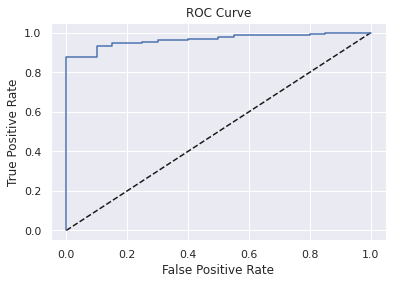

In [ ]:
# define a function to generate the ROC curve
def plot_roc(mod, X, y):
    prediction = model.predict(X_test)
    fpr, tpr, _ = metrics.roc_curve(y, prediction)

# plot ROC curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    
plot_roc(model, X_test, y_test)

Also, it can be seen from the figure that the area below the ROC curve is closer to 1, compared to the logistic, random forest and SVM models.

**Convolutional Neural Networks(CNN)**



In [ ]:
!pip install tensorflow-gpu==2.0.0

In [ ]:
# prepare the data for running the following model
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [ ]:
# build the model and evaluate it
model=Sequential()
model.add(Conv1D(32,2,activation='relu',input_shape=X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(64,2,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
hist=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=1)
model.evaluate(X_test, y_test)

Epoch 1/30
213/213 [==============================] - 2s 6ms/step - loss: 0.6920 - accuracy: 0.7231 - val_loss: 0.9157 - val_accuracy: 0.2077
Epoch 2/30
213/213 [==============================] - 1s 5ms/step - loss: 0.1634 - accuracy: 0.9481 - val_loss: 0.1759 - val_accuracy: 0.9715
Epoch 3/30
213/213 [==============================] - 1s 5ms/step - loss: 0.1000 - accuracy: 0.9762 - val_loss: 0.0576 - val_accuracy: 0.9931
Epoch 4/30
213/213 [==============================] - 1s 5ms/step - loss: 0.0889 - accuracy: 0.9844 - val_loss: 0.0506 - val_accuracy: 0.9931
Epoch 5/30
213/213 [==============================] - 1s 5ms/step - loss: 0.0786 - accuracy: 0.9876 - val_loss: 0.0479 - val_accuracy: 0.9931
Epoch 6/30
213/213 [==============================] - 1s 5ms/step - loss: 0.0681 - accuracy: 0.9900 - val_loss: 0.0460 - val_accuracy: 0.9931
Epoch 7/30
213/213 [==============================] - 1s 5ms/step - loss: 0.0686 - accuracy: 0.9884 - val_loss: 0.0446 - val_accuracy: 0.9931
Epoch 

[0.03387036174535751, 0.9931342005729675]

In [ ]:
# make prediction and calculate the ROC-AUC score for the prediction
preds = model.predict(X_test)
roc_auc_score(y_test, preds)

0.9345143449706187

We can notice that the accuracy of this model is really high, but the ROC-AUC score for the prediction is lower than Logistic model and LightGBM model. We think this may be due to the large size of the neural network model but the small data set in comparison, thus creating the overfitting problem. In addition, CNN has a longer training time.

In [ ]:
model=lgb.LGBMClassifier(learning_rate=0.05,max_depth=4,random_state=42)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],verbose=0,eval_metric='logloss')
predict=model.predict(X_test)
predict # most clients have a low credit risk prediction("CREDIT_APPROVAL_STATUS"=1)

array([1, 1, 1, ..., 1, 1, 1])

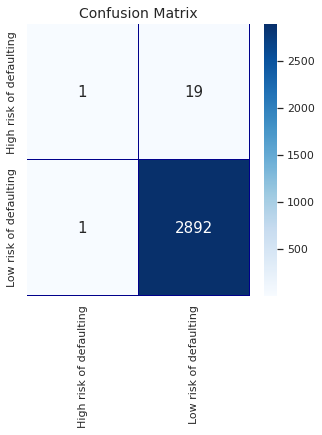

In [ ]:
# confusion matrix
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, annot=True,ax=ax, fmt='d',
            xticklabels=['High risk of defaulting','Low risk of defaulting'],
            yticklabels=['High risk of defaulting','Low risk of defaulting'],
            linewidths=.2,linecolor="Darkblue", cmap="Blues",annot_kws={'size': 15})
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Although it is true that the number of low-risk defaults is much larger than high-risk defaults in both actual and predicted values, the results of the confusion matrix suggest that the LightGBM model still lacks accuracy in predicting high-risk defaults behavior. With the extreme imbalance of the data, even though we have adjusted the weight of two types of data in the LightGBM model, it prefers to consider the clients as low risk. However, the LightGBM model is indeed the fitted among all models when compared with another evaluate indicator-AUC score. Therefore, although it is the best model and prediction result that can be obtained in this project, how to better address the impact of data imbalance is also an issue that I need to further explore and enhance subsequently.

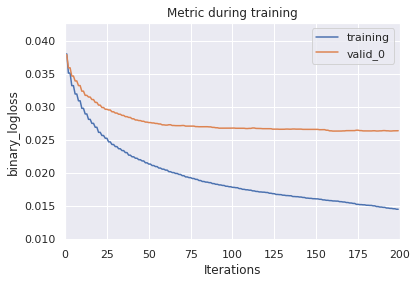

In [ ]:
lgb.plot_metric(model)

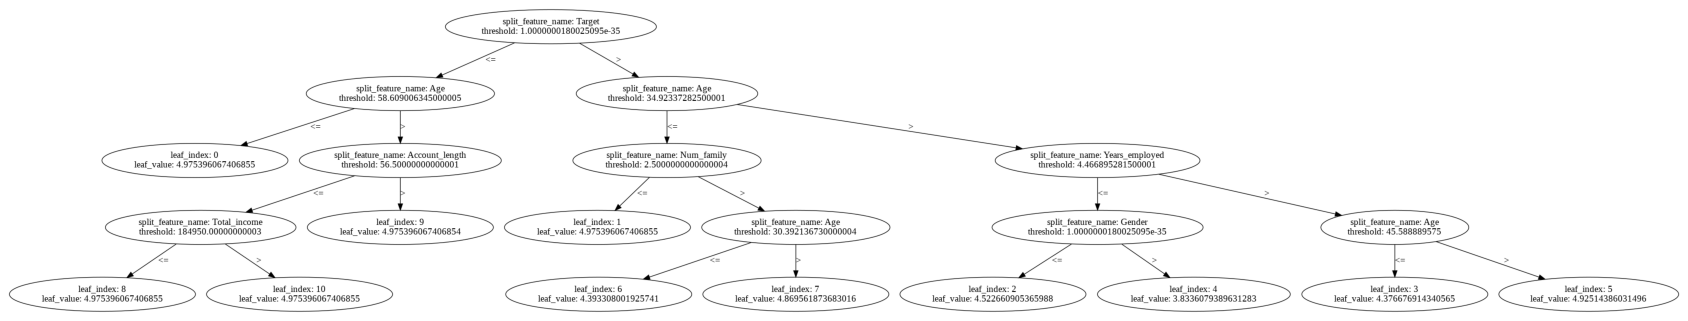

In [ ]:
lgb.plot_tree(model,figsize=(30,40))

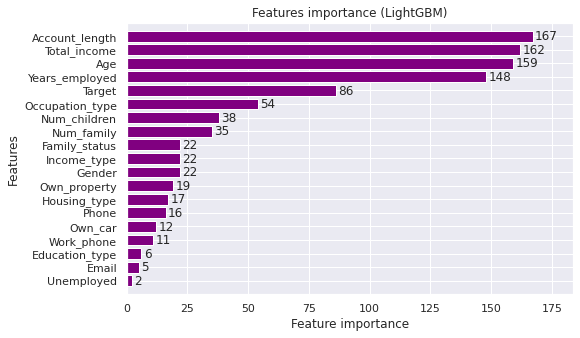

In [ ]:
# plot fearure importance
fig,(ax)= plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model,height=0.8,title="Features importance (LightGBM)",ax=ax,color="purple") 
plt.show()

As shown in the figure, the time length of holding a bank account, total income, age, years of employment and job category are some of the most important factors that influence a client's risk of credit fraud. In particular, the high-risk clients group tend to have shorter bank account time length, lower income, shorter years of employment and so on. 